In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [35]:
%%time

df = pd.read_csv('data/examples_with_length_speech2vec_vocab.csv')
df = df[df.in_speech2vec_vocab]
df.shape

CPU times: user 26.4 s, sys: 3.08 s, total: 29.5 s
Wall time: 29.5 s


(14057950, 12)

In [2]:
words = set(df.source_word.unique().tolist() + df.target_word.unique().tolist())

NameError: name 'df' is not defined

In [3]:
d = {
    'A':'dot dash',
    'B':'dash dot dot dot',
    'C':'dash dot dash dot',
    'D':'dash dot dot',
    'E':'dot',
    'F':'dot dot dash dot',
    'G':'dash dash dot',
    'H':'dot dot dot dot',
    'I':'dot dot',
    'J':'dot dash dash dash',
    'K':'dash dot dash',
    'L':'dot dash dot dot',
    'M':'dash dash',
    'N':'dash dot',
    'O':'dash dash dash',
    'P':'dot dash dash dot',
    'Q':'dash dash dot dash',
    'R':'dot dash dot',
    'S':'dot dot dot',
    'T':'dash',
    'U':'dot dot dash',
    'V':'dot dot dot dash',
    'W':'dot dash dash',
    'X':'dash dot dot dash',
    'Y':'dash dot dash dash',
    'Z':'dash dash dot dot',
    '\'':'dot dash dash dash dash dot'
}
# dot=1
# dash=3
# space=1
# between letters = 3
# between words = 4

SR = 16000

unit = 0.15
u = np.linspace(0, unit, int(unit*SR))
dot = np.sin(2 * np.pi * 440 * u)
spot = np.zeros_like(u)
dot.shape, spot.shape

m = {
    'dot': dot,
    ' ': spot,
    'dash': np.concatenate([dot, dot, dot]),
    r'/': np.concatenate([spot, spot, spot])
}

def word2morseword(word):
    morseword = ''
    for i, letter in enumerate(word):
        if i == 0:
            morseword += d[letter]
        else:
            morseword += '/'
            morseword += d[letter]
    return morseword

def morseword2morseaudio(morseword):
    morseaudio = []
    for i, morseletter in enumerate(re.split('/', morseword)):
        if i == 0:
            for j, feature in enumerate(re.split('\s', morseletter)):
                if j == 0:
                    morseaudio.append(m[feature])
                else:
                    morseaudio.append(m[' '])
                    morseaudio.append(m[feature])
        else:
            morseaudio.append(m[r'/'])
            for j, feature in enumerate(re.split('\s', morseletter)):
                if j == 0:
                    morseaudio.append(m[feature])
                else:
                    morseaudio.append(m[' '])
                    morseaudio.append(m[feature])
    morseaudio = np.concatenate(morseaudio)
    return morseaudio
    
def word2morse(word):
    morseword = word2morseword(word)
    morse = morseword2morseaudio(morseword)
    return morse

def show_spectrogram(morse):
    S = librosa.stft(morse, n_fft=1024, hop_length=1024//16)
    plt.imshow(np.abs(S), aspect='auto')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()
    display(Audio(morse, rate=SR))

In [4]:
from IPython.lib.display import Audio

In [6]:
import librosa

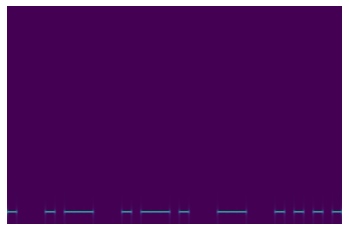

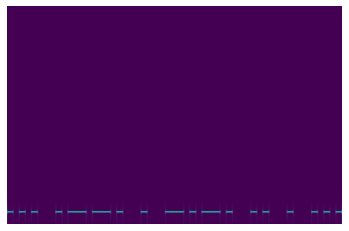

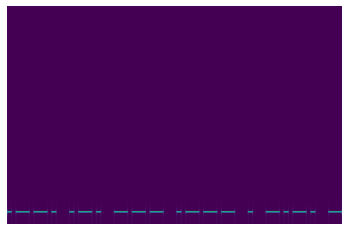

In [7]:
morsecat = word2morse('EARTH')
show_spectrogram(morsecat)
morsecat = word2morse('SPECIES')
show_spectrogram(morsecat)
morsecat = word2morse('PROJECT')
show_spectrogram(morsecat)

In [8]:
original = word2morse('ENCODING')
encoded = librosa.mu_compress(original, mu=2**5-1, quantize=True)

In [9]:
print('Original:')
display(Audio(original, rate=SR))
print('Encoded:')
display(Audio(encoded, rate=SR))

Original:


Encoded:


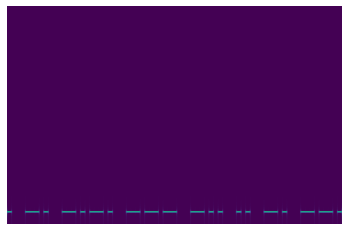

In [10]:
show_spectrogram(original)

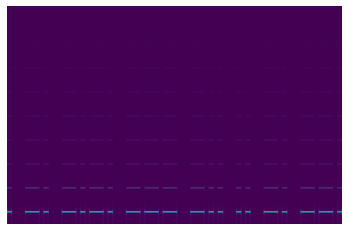

In [11]:
show_spectrogram(encoded.astype('float32'))

In [64]:
words = list(words)
audio = word2morse(`)

In [65]:
from python_speech_features.base import mfcc

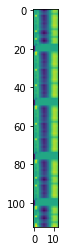

In [67]:
plt.imshow(mfcc(audio))

In [70]:
word2morseword(words[0])

'dot dash dot dot/dash dash dash/dash dash dash/dash dot dash/dot dot dot'

In [108]:
m = {
    'dot': [1],
    ' ': [0],
    'dash': [1,1,1],
    r'/': [0,0,0]
}

In [174]:
def morseword2array(word):
    str_representation = word2morseword(word)
    ary = []
    for letter in str_representation.split('/'):
        for character in letter.split(' '):
            ary += m[character]
            ary += m[' ']
        ary += m['/']
    return np.array(ary).reshape(-1, 1)

In [175]:
morseword2array(words[0])

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [219]:
word2features = {word: morseword2array(word) for word in words}

In [220]:
max_length = 0
for word, features in  word2features.items():
    max_length = max(max_length, features.shape[0])

In [221]:
max_length

190

In [222]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

train_examples.reset_index(inplace=True, drop=True)
valid_examples.reset_index(inplace=True, drop=True)

In [223]:
def prepare_features(word, pad_to=190, pad_left=True):
    ary = word2features[word]
    example = np.zeros((pad_to, 1))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [224]:
prepare_features(words[0]).shape

(190, 1)

In [225]:
class Dataset():
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        source_word = self.df.source_word[idx]
        target_word = self.df.target_word[idx]
        return prepare_features(source_word), word2index[target_word]

In [226]:
train_ds = Dataset(train_examples)
valid_ds = Dataset(valid_examples)

len(train_ds), len(valid_ds)

(13902718, 155232)

In [227]:
word2index = {word: i for i, word in enumerate(words)}

In [228]:
BS = 1024
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [188]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

umount: /dev/shm/: target is busy
        (In some cases useful info about processes that
         use the device is found by lsof(8) or fuser(1).)


In [229]:
class Model(Module):
    def __init__(self, hidden_size=150):
        self.return_embeddings = False
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
#         self.dr = nn.Dropout(0.1)
        self.linear = nn.Linear(2*hidden_size, len(words))
            
    def forward(self, source_features):
        _, (embeddings, _) = self.encoder(source_features)      
        
        # embeddings.view(num_layers, num_directions, batch, hidden_size)
        embeddings = embeddings.view(1, 2, source_features.shape[0], self.hidden_size)
        embeddings = torch.cat((embeddings[-1, 0], embeddings[-1, 1]), -1)
        
        if self.return_embeddings: return embeddings

#         embeddings = self.dr(embeddings)
        return self.linear(embeddings)

In [230]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [231]:
NUM_EPOCHS = 20
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.589837,6.654756,0.085807,15:07
1,6.534158,6.548440,0.090239,15:10
2,6.469579,6.520371,0.091689,15:08
3,6.447022,6.502333,0.092197,15:10
4,6.419604,6.494435,0.092687,15:19
5,6.469521,6.514307,0.091193,15:22
6,6.440834,6.496212,0.092152,15:20
7,6.414642,6.487654,0.092893,15:05
8,6.420955,6.482948,0.092410,15:13
9,6.421563,6.481706,0.093177,15:19


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

## Calculate embedding for each unique word in the dataset

In [232]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

all_dl = DataLoader(Dataset(df_unique_utterances), BS, NUM_WORKERS)

In [233]:
%%time

learn.model.return_embeddings = True
learn.model.eval()

all_embeddings = []

with torch.no_grad():    
    for batch in all_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 1min 8s, sys: 15 s, total: 1min 23s
Wall time: 1min 27s


In [234]:
all_embeddings = torch.cat(all_embeddings)
all_embeddings.shape

torch.Size([4528719, 300])

In [235]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')

In [237]:
def empty_list(): return list()

In [238]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances_speech2vec_vocab_min_length_20_max_length_70_only_driect_neighbors.pkl')

In [239]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0).numpy()

In [240]:
from utils import Embeddings

In [241]:
e = Embeddings(
    np.array(list(word2embedding.values())),
    [w.lower() for w in list(word2embedding.keys())]
)

In [242]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'eyes', 'never', 'with', 'end']
lost: ['lost', 'no', 'was', 'now', 'not']
small: ['small', 'he', 'that', 'and', 'then']
true: ['true', 'that', 'too', 'not', 'place']
crazy: ['crazy', 'hastily', 'else', 'entered', 'breast']
slow: ['slow', 'were', 'air', 'good', 'love']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [243]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [244]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [245]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding.keys())]),
    np.array(list(word2embedding.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [246]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 408 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 65 words. Will replace them with mean vector
Missing 26 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.05039475015618127
Spearman correlation of scores on WS353 -0.01816467166256991
Spearman correlation of scores on SIMLEX999 -0.15021521443827904


In [247]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


## Loss decrease and improvements on semantic tasks as training progresses

In [248]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(NUM_EPOCHS):
    learn.load(f'morse_{i}')
    learn.model.return_embeddings = False
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    learn.model.return_embeddings = True
    learn.model.eval()

    all_embeddings = []

    with torch.no_grad():    
        for batch in all_dl:
            embeddings = learn.model(batch[0].cuda())
            all_embeddings.append(embeddings.detach().cpu().squeeze(0))

    all_embeddings = torch.cat(all_embeddings)

    word2embedding = {}
    for k, v in word2row_idxs_unique_utterances.items():
        word2embedding[k] = all_embeddings[np.array(v)].mean(0).numpy()

    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in list(word2embedding.keys())]),
        np.array(list(word2embedding.values()))
    )
    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [249]:
men, ws353, simlex999 = list(zip(*task_perf))

In [250]:
import matplotlib.pyplot as plt

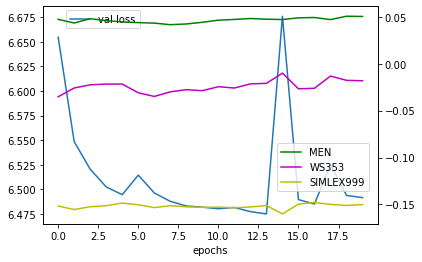

In [251]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')


ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');

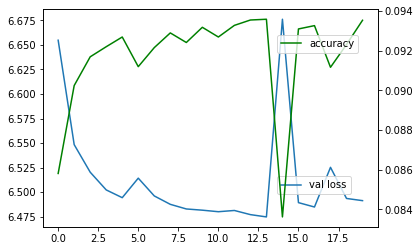

In [252]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(accuracies, label='accuracy', c='g')

ax1.legend(loc=[0.7, 0.15])
ax2.legend(loc=[0.7, 0.8])